Next, create a 2D graph illustrating the relationship between P and QAOA Runtime, with each value of N fixed from 1 to 10.

今度は、Nを１から１０の各値で固定したときの、PとQAOAのRunTimeの関係を２次元グラフに表す。

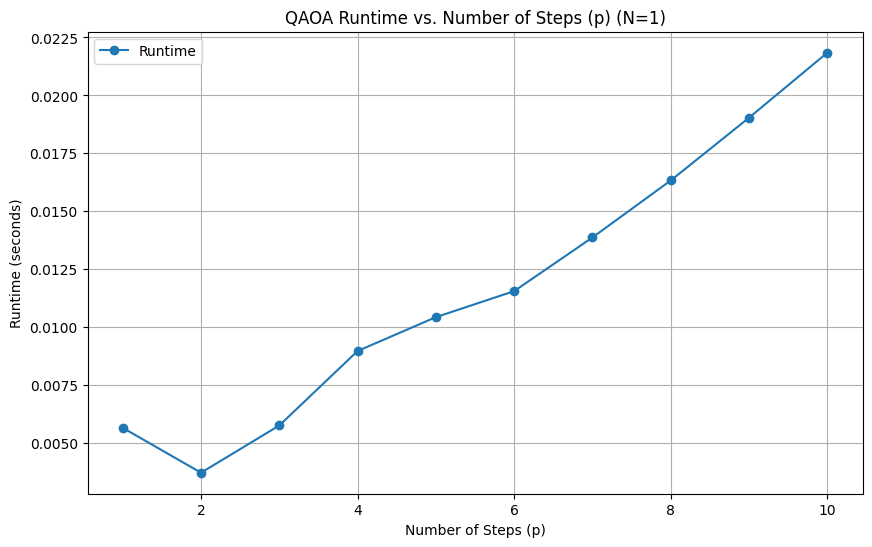

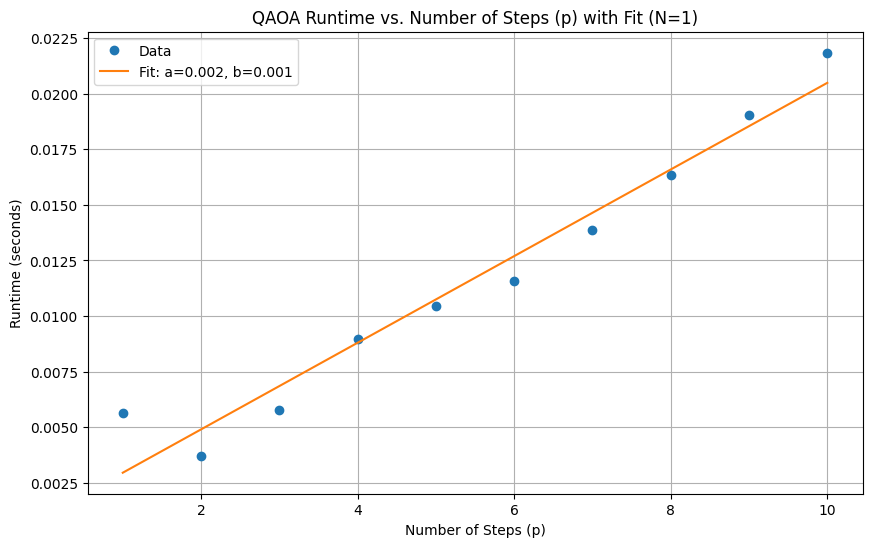

N=1: Fitted parameters (a, b): [0.00194835 0.00100379]


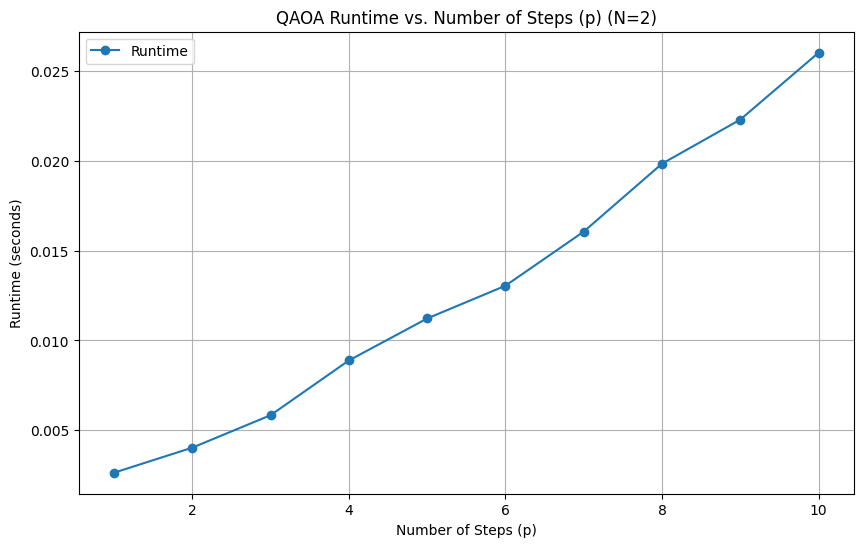

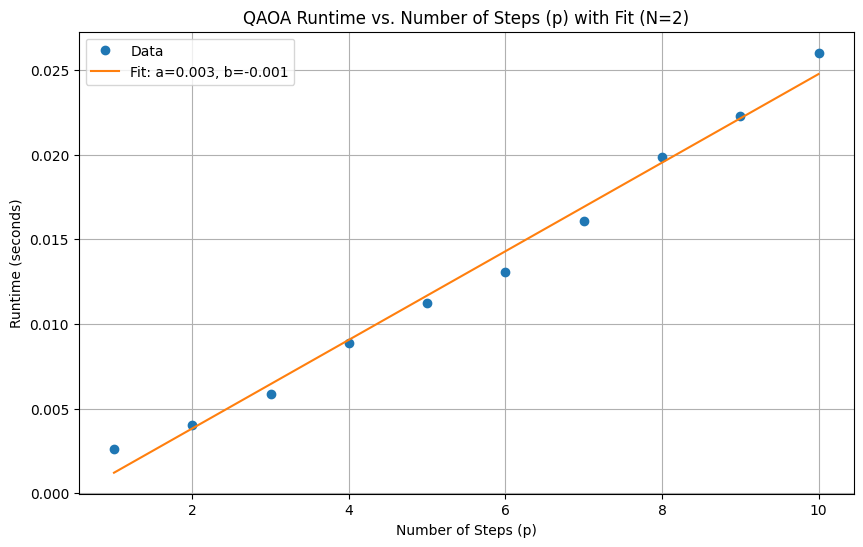

N=2: Fitted parameters (a, b): [ 0.00261495 -0.00139534]


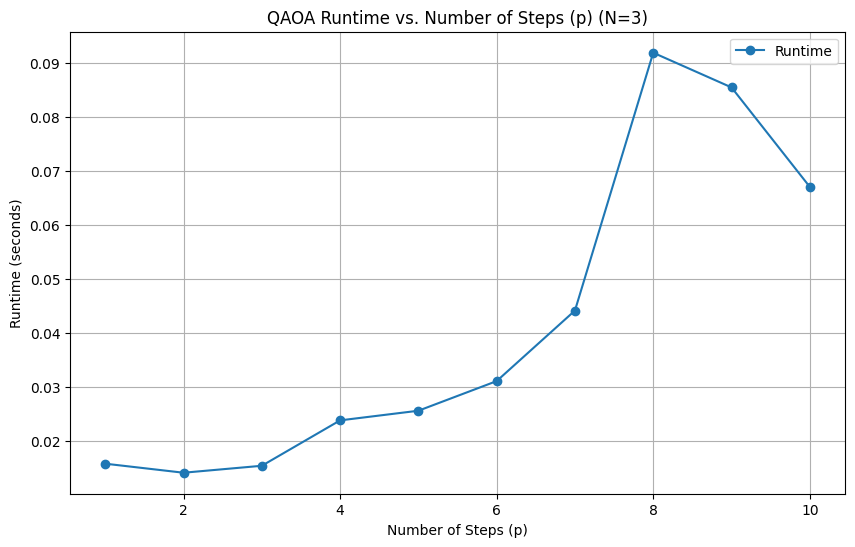

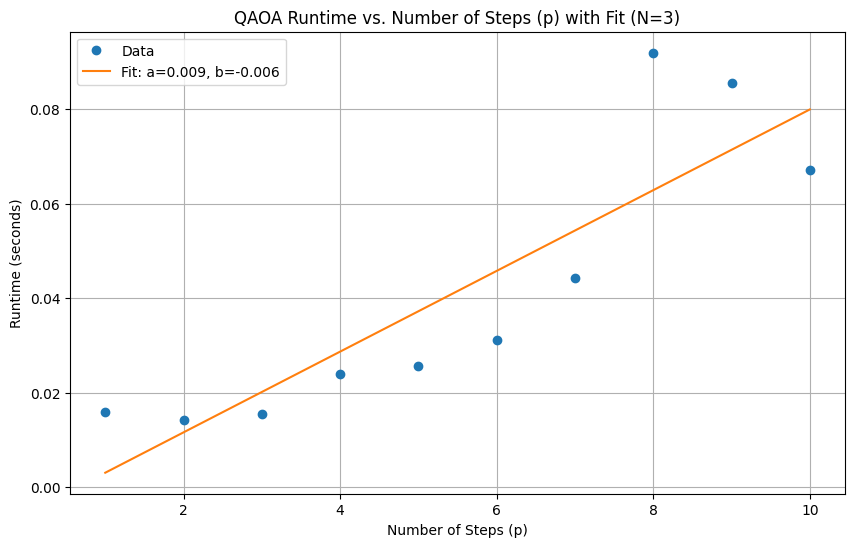

N=3: Fitted parameters (a, b): [ 0.0085454  -0.00551496]


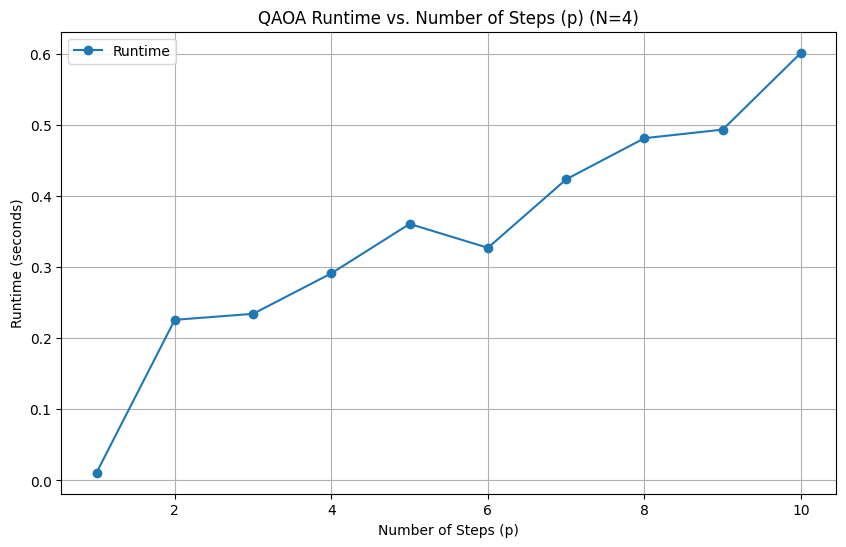

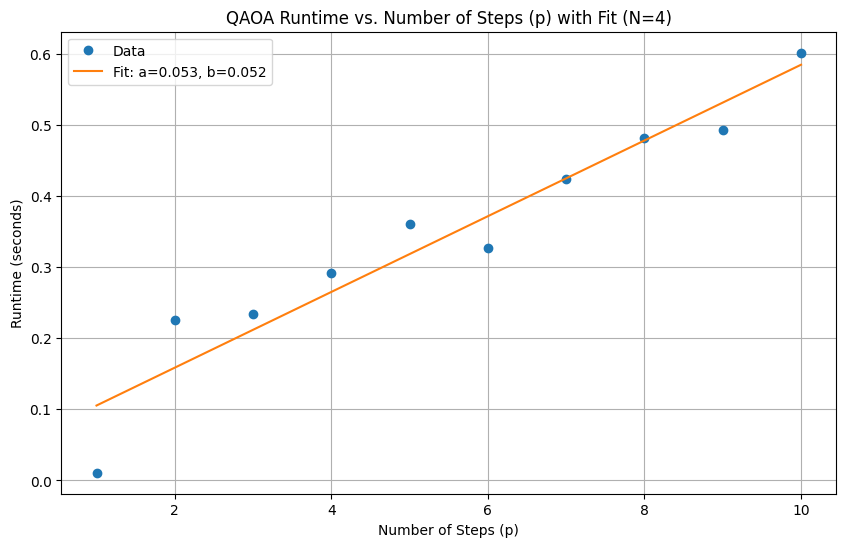

N=4: Fitted parameters (a, b): [0.05323231 0.05205156]


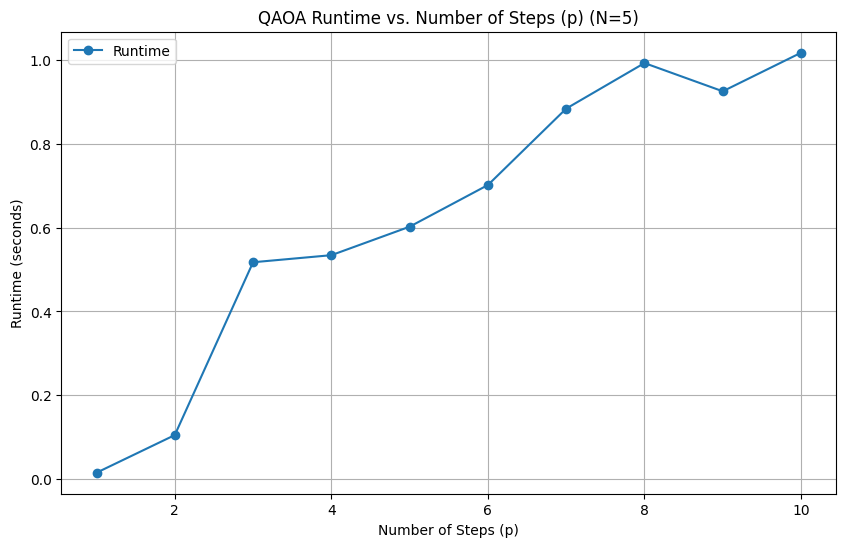

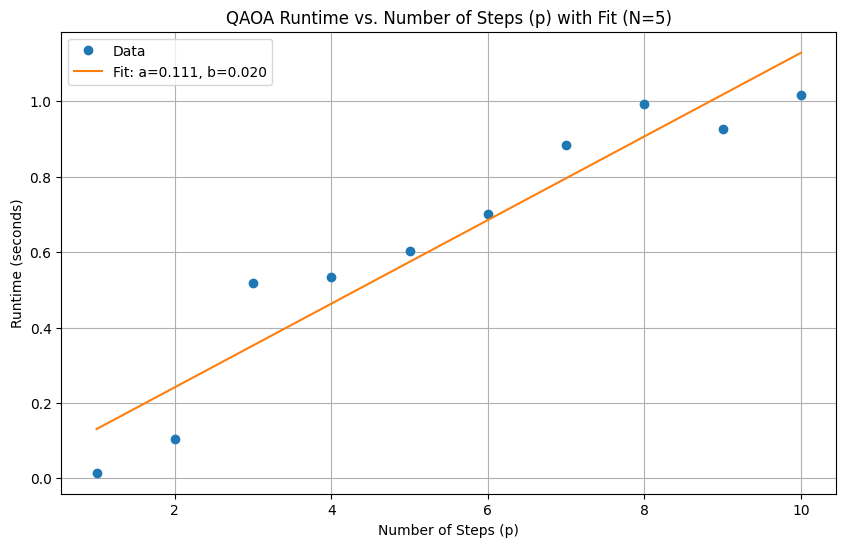

N=5: Fitted parameters (a, b): [0.11093361 0.01957026]


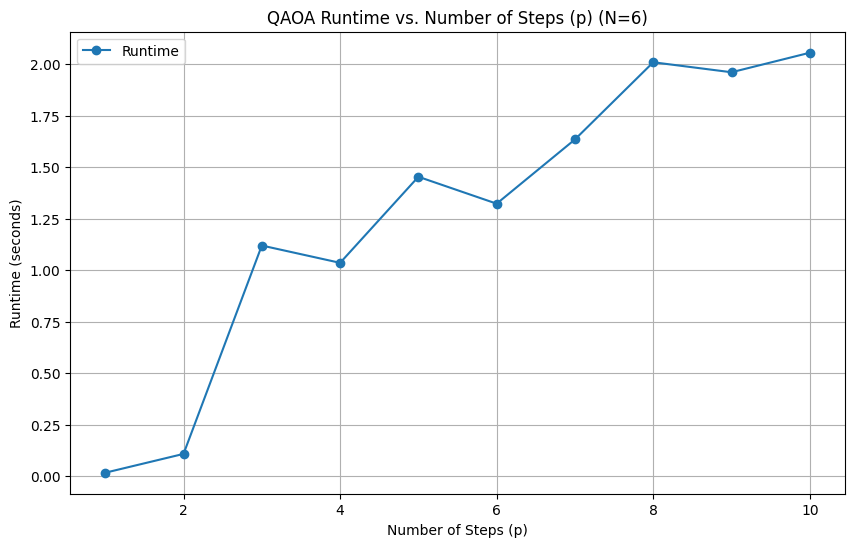

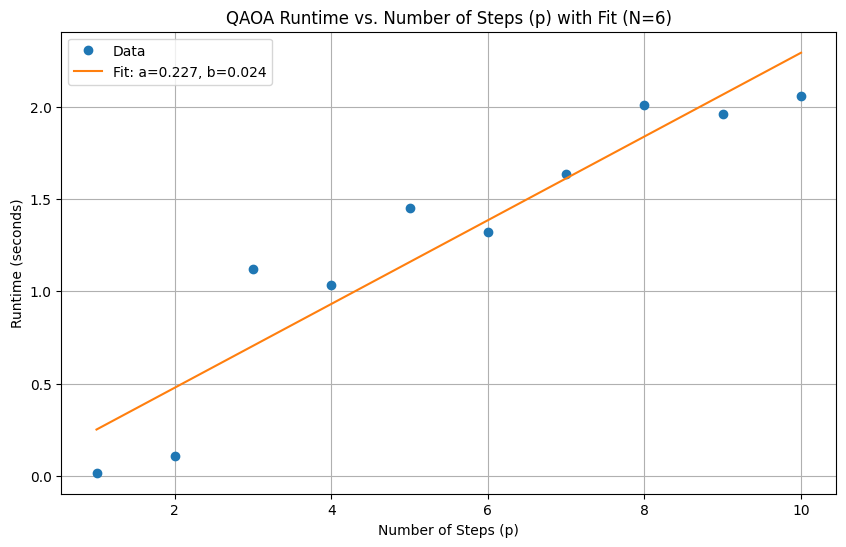

N=6: Fitted parameters (a, b): [0.22680656 0.02383067]


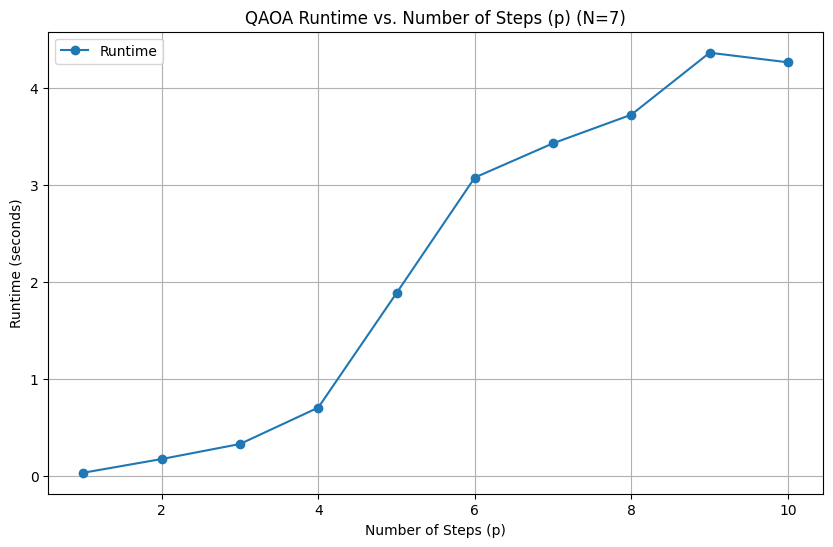

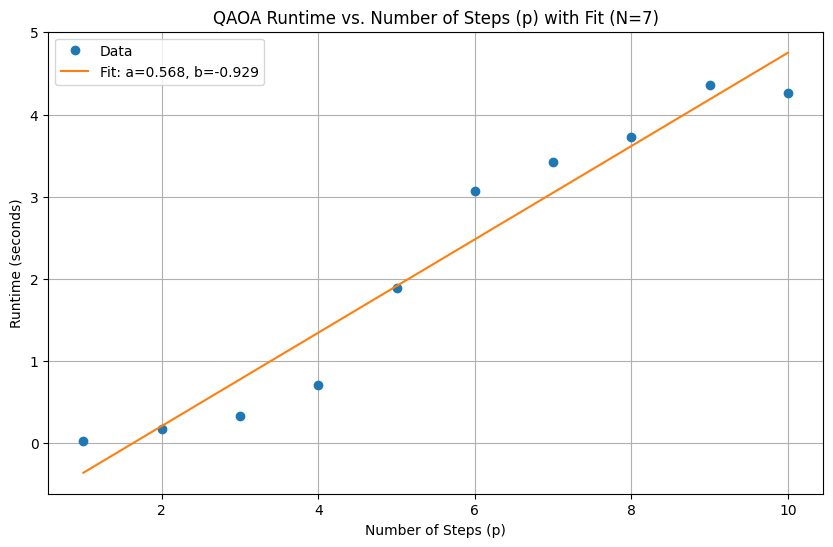

N=7: Fitted parameters (a, b): [ 0.56817335 -0.92943669]


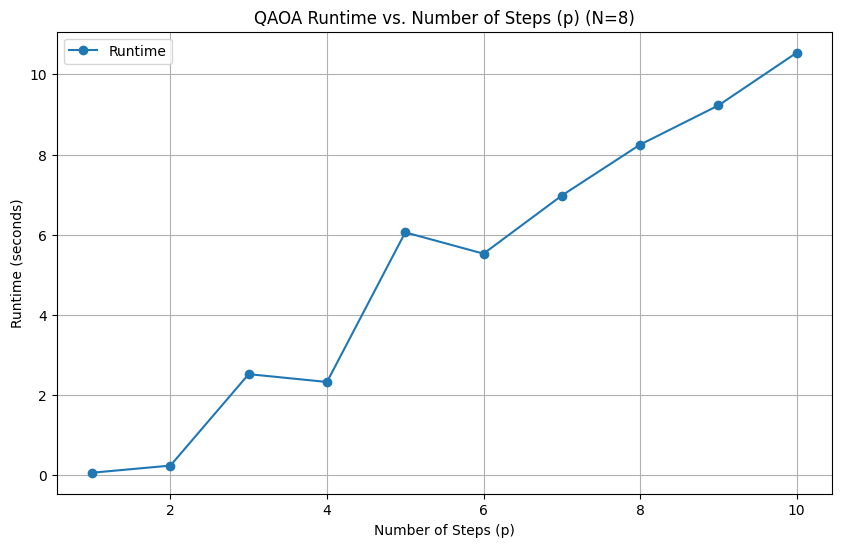

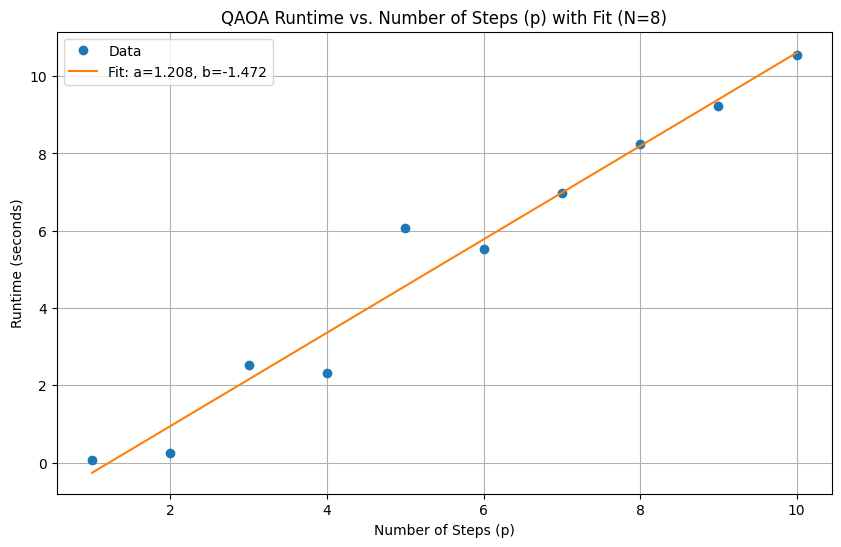

N=8: Fitted parameters (a, b): [ 1.20786959 -1.47235541]


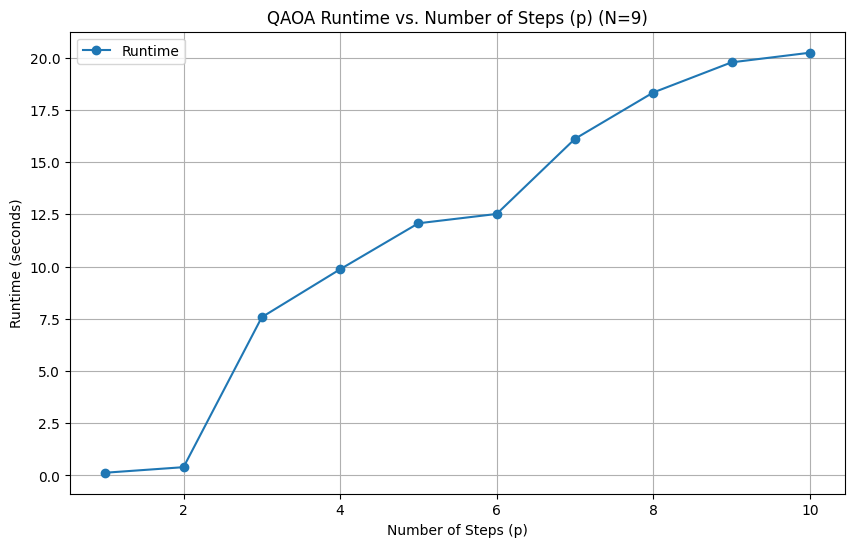

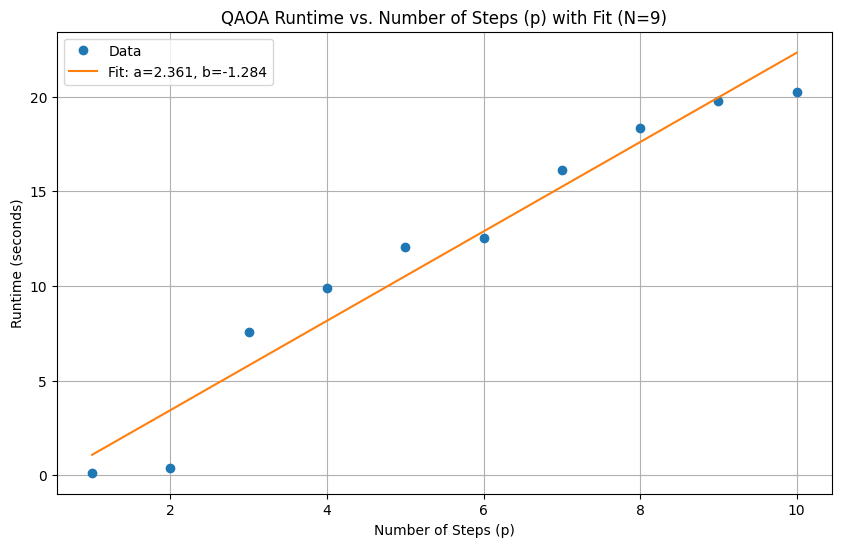

N=9: Fitted parameters (a, b): [ 2.36088848 -1.28426811]


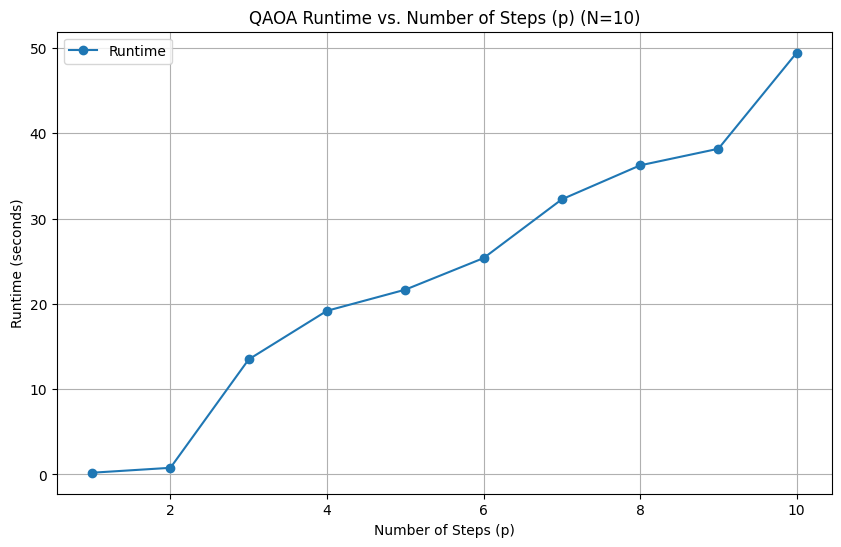

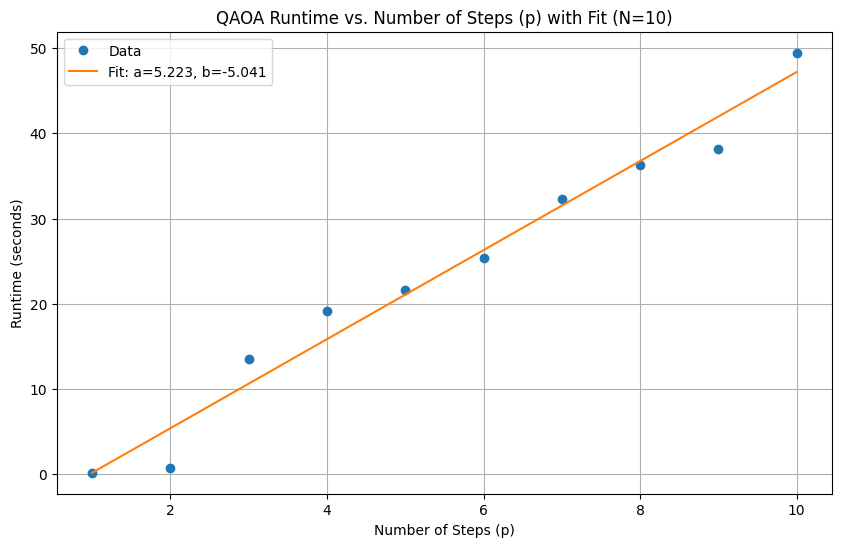

N=10: Fitted parameters (a, b): [ 5.22321115 -5.04126725]


In [3]:
import typing
import qokit
import numpy as np
import scipy
import time
import matplotlib.pyplot as plt
import networkx as nx
from qokit.fur.qaoa_simulator_base import QAOAFastSimulatorBase, TermsType
import os  # osモジュールのインポートを追加

# QAOA用の関数定義
def get_simulator(N: int, terms: TermsType, sim_or_none: QAOAFastSimulatorBase | None = None) -> QAOAFastSimulatorBase:
    if sim_or_none is None:
        simclass = qokit.fur.choose_simulator(name="auto")
        return simclass(N, terms=terms)
    else:
        return sim_or_none

def get_result(
    N: int, terms: TermsType, gamma: np.ndarray, beta: np.ndarray, sim: QAOAFastSimulatorBase | None = None, result: np.ndarray | None = None
) -> np.ndarray:
    if result is None:
        simulator = get_simulator(N, terms, sim)
        return simulator.simulate_qaoa(gamma, beta)
    else:
        return result

def get_simulator_and_result(
    N: int, terms: TermsType, gamma: np.ndarray, beta: np.ndarray, sim: QAOAFastSimulatorBase | None = None, result: np.ndarray | None = None
) -> tuple[QAOAFastSimulatorBase, np.ndarray]:
    simulator = get_simulator(N, terms, sim)
    if result is None:
        result = get_result(N, terms, gamma, beta, simulator)
    return (simulator, result)

def get_state(N: int, terms: TermsType, gamma: np.ndarray, beta: np.ndarray, sim: QAOAFastSimulatorBase | None = None, result: np.ndarray | None = None):
    simulator, result = get_simulator_and_result(N, terms, gamma, beta, sim, result)
    return simulator.get_statevector(result)

def get_probabilities(
    N: int, terms: TermsType, gamma: np.ndarray, beta: np.ndarray, sim: QAOAFastSimulatorBase | None = None, result: np.ndarray | None = None
) -> np.ndarray:
    simulator, result = get_simulator_and_result(N, terms, gamma, beta, sim, result)
    return simulator.get_probabilities(result, preserve_state=True)

def get_expectation(
    N: int, terms: TermsType, gamma: np.ndarray, beta: np.ndarray, sim: QAOAFastSimulatorBase | None = None, result: np.ndarray | None = None
) -> float:
    simulator, result = get_simulator_and_result(N, terms, gamma, beta, sim, result)
    return simulator.get_expectation(result, preserve_state=True)

def get_overlap(
    N: int, terms: TermsType, gamma: np.ndarray, beta: np.ndarray, sim: QAOAFastSimulatorBase | None = None, result: np.ndarray | None = None
) -> float:
    simulator, result = get_simulator_and_result(N, terms, gamma, beta, sim, result)
    return simulator.get_overlap(result, preserve_state=True)

def inverse_objective_function(ising_model: TermsType, N: int, p: int, mixer: str, states: list[np.ndarray] | None) -> typing.Callable:
    def inverse_objective(*args) -> float:
        gamma, beta = args[0][:p], args[0][p:]
        simulator, result = get_simulator_and_result(N, ising_model, gamma, beta)
        expectation = get_expectation(N, ising_model, gamma, beta, simulator, result)

        if states is not None:
            states.append(get_state(N, ising_model, gamma, beta, simulator, result))

        return -expectation

    return inverse_objective

def QAOA_run(
    ising_model: TermsType,
    N: int,
    p: int,
    init_gamma: np.ndarray,
    init_beta: np.ndarray,
    optimizer_method: str = 'COBYLA',
    optimizer_options: dict | None = None,
    mixer: str = "x",  # Using a different mixer is not yet supported
    states: list[np.ndarray] | None = None,
) -> dict:
    init_freq = np.hstack([init_gamma, init_beta]) 

    start_time = time.time()
    result = scipy.optimize.minimize(
        inverse_objective_function(ising_model, N, p, mixer, states), init_freq, method=optimizer_method, options=optimizer_options
    ) 
    end_time = time.time()

    gamma, beta = result.x[:p], result.x[p:]

    return {
        "gamma": gamma,
        "beta": beta,
        "state": get_state(N, ising_model, gamma, beta),
        "expectation": get_expectation(N, ising_model, gamma, beta),
        "overlap": get_overlap(N, ising_model, gamma, beta),
        "runtime": end_time - start_time,  # measured in seconds
        "num_QAOA_calls": result.nfev,
        "classical_opt_success": result.success,
        "scipy_opt_message": result.message
    }

# Max-Cut Ising Modelを生成する関数
def generate_maxcut_ising_terms(G: nx.Graph) -> TermsType:
    terms = []
    for i, j in G.edges():
        terms.append((-1, (i, j)))  # Max-CutのIsingモデルのためのJij=-1
    return terms

# 近似関数の定義
def fit_function(p, a, b):
    return a * p + b

# パラメータ設定
max_p = 10  # pの最大値
Ns = range(1, 11)  # Nの範囲

# ランダムシードの設定
np.random.seed(0)

# 保存先ディレクトリを指定
save_dir = "data_for_graphs_Predict(2)"
os.makedirs(save_dir, exist_ok=True)  # ディレクトリが存在しない場合は作成する

# 各Nについての処理
for N in Ns:
    runtimes = []
    ps = range(1, max_p + 1)

    # ランダムグラフ生成
    G = nx.erdos_renyi_graph(N, 0.5, seed=0)
    ising_model = generate_maxcut_ising_terms(G)

    # QAOA実行とランタイム計算
    for p in ps:
        init_gamma, init_beta = np.random.rand(2, p)
        qaoa_result = QAOA_run(ising_model, N, p, init_gamma, init_beta, "COBYLA")
        runtimes.append(qaoa_result["runtime"])

    # ランタイムのプロット
    plt.figure(figsize=(10, 6))
    plt.plot(ps, runtimes, 'o-', label="Runtime")
    plt.xlabel("Number of Steps (p)")
    plt.ylabel("Runtime (seconds)")
    plt.title(f"QAOA Runtime vs. Number of Steps (p) (N={N})")
    plt.legend()
    plt.grid(True)
    plt.show()
    np.save(f"data_for_graphs_Predict(2)/data_for_QAOA_RunTime_vs_p_N={N}_Ns_kanon",ps)
    np.save(f"data_for_graphs_Predict(2)/data_for_QAOA_RunTime_vs_p_N={N}_runtimes_kanon",runtimes)

    # データのフィッティング
    params, _ = scipy.optimize.curve_fit(fit_function, ps, runtimes)

    # フィッティング結果のプロット
    plt.figure(figsize=(10, 6))
    plt.plot(ps, runtimes, 'o', label='Data')
    plt.plot(ps, fit_function(ps, *params), '-', label=f'Fit: a={params[0]:.3f}, b={params[1]:.3f}')
    plt.xlabel('Number of Steps (p)')
    plt.ylabel('Runtime (seconds)')
    plt.title(f'QAOA Runtime vs. Number of Steps (p) with Fit (N={N})')
    plt.legend()
    plt.grid(True)
    plt.show()
    np.save(f"data_for_graphs_Predict(2)/data_for_QAOA_RunTime_vs_p_N={N}_with_fit_Ns_kanon",ps)
    np.save(f"data_for_graphs_Predict(2)/data_for_QAOA_RunTime_vs_p_N={N}_with_fit_runtimes_kanon",runtimes)
    np.save(f"data_for_graphs_Predict(2)/data_for_QAOA_RunTime_vs_p_N={N}_with_fit_params_kanon",params)

    # フィッティング結果のパラメータ出力
    print(f"N={N}: Fitted parameters (a, b):", params)

It's understood that the graph will be upward sloping, but predicting it using an approximation function seems challenging.

右肩上がりのグラフになることはわかっても、近似関数を使って予測することは難しそうである。